In [ ]:
import numpy as np
import math

class GridWorld:
    def __init__(self,k,d,noise,size=8,danger=[7,1],goal=[4,5],wall=[2,5],coins=[(1,6),(4,2),(5,5)], horizon=50, feedback_every=10):
        self.noise = noise
        self.k=k
        self.d=d
        self.size = size
        self.horizon = horizon
        self.goal = tuple(goal)
        self.danger = tuple(danger)
        self.wall = tuple(wall)
        self._init_coins = tuple(map(tuple, coins)) 
        self.coins = set(self._init_coins)
        self.collected_coins = set()
        self.done = 0
        self.feedback_every = feedback_every
        self.gamma = 1
        self.previous_pos = None
    
    def reset(self, random=False):
        self.done = 0
        self.t = 0
        self.collected = 0
        self.collected_coins = set()
        self.coins = set(self._init_coins)
        self.previous_pos = None

        if random:
            while True:
                r = np.random.randint(0, self.size)
                c = np.random.randint(0, self.size)
                potential_start = (r, c)
                
                # Check if the potential start is one of the terminal/wall states
                if potential_start not in {self.goal, self.danger, self.wall}:
                    self.pos = potential_start
                    break
        else:
            self.pos = (7, 0)

        return self.pos
    
    def step(self, intended_action):
        self.previous_pos = self.pos
        probs = np.full(4, 0.03)
        probs[intended_action] = 0.91
        action = np.random.choice(4, p=probs)
        x, y = self.pos
        if action == 0: x = max(0, x-1)       # up
        if action == 1: x = min(self.size-1, x+1) # down
        if action == 2: y = max(0, y-1)       # left
        if action == 3: y = min(self.size-1, y+1) # right
        if((x,y)!=(self.wall)):
            self.pos = (x,y)
        if self.pos in self.coins:
            self.collected += 1
            self.collected_coins.add(self.pos)
            self.coins.remove(self.pos)
        self.t += 1
        self.done = ((self.t >= self.horizon)or (self.pos==self.goal) or (self.pos==self.danger))
        return self.pos, self.done

    def get_feedback(self):
        # Calculate the base True Reward (Terminal only or just the coins collected)
        # Base reward: Coin collection + Goal arrival bonus
        weights = [0.1, 1.0, 2.0, 3.0] # Your original weights

        true_reward = (1-(self.pos==self.danger))*(weights[self.collected]*(self.collected + 1.32*(self.pos==self.goal)) - 5*(self.t-14)/self.horizon + 5*36/50)

        scaled_reward = 2*true_reward

        ## now we quantize it into k bins
        edges = np.linspace(0,32.92,self.k+1)
        feedback = self.k-1
        for i in range(len(edges)-1):
            if(edges[i]<=scaled_reward and scaled_reward<edges[i+1]):
                feedback = i
                break

       # label noise
        probs = [0.0] * self.k
        probs[feedback] = 1-self.noise+self.noise/self.k
        rem = 1-probs[feedback]
        rem_distributed = rem / (self.k - 1)
        for i in range(self.k):
            if probs[i] == 0.0:
                probs[i] = rem_distributed
   
        feedback_list = [i for i in range(self.k)]
        feedback_given = np.random.choice(feedback_list,p=probs)
        return feedback_given, feedback
                
    
    def _features(self):
        """return trajectory features phi(tau)"""
        x, y = self.pos
        xg, yg = self.goal
        xd, yd = self.danger
        dist_to_goal = abs(x-xg) + abs(y-yg)
        dist_to_danger = abs(x-xd) + abs(y-yd)
        at_danger = int(self.pos == self.danger)
        at_goal = int(self.pos == self.goal and (at_danger==0))
        coin_indicator = [int(c in self.collected_coins) for c in self._init_coins]
        return np.array([dist_to_goal, dist_to_danger, at_goal, at_danger] + coin_indicator, dtype=float)
        

def softmax(logits):
    exps = np.exp(logits - np.max(logits))
    return exps / np.sum(exps)

class Policy:
    def __init__(self, grid_size, action_dim):
        self.grid_size = grid_size
        self.state_dim = grid_size * grid_size
        self.action_dim = action_dim
        self.theta = np.ones((self.state_dim, self.action_dim))
    
    def state_index(self, state):
        return state[0] * self.grid_size + state[1]
    
    def act(self, state):
        s_idx = self.state_index(state)
        probs = softmax(self.theta[s_idx])
        action = np.random.choice(len(probs), p=probs)
        return action, probs
    
    def grad_log_prob(self, state, action):
        """Return (state_index, grad_row) with grad_row shape (action_dim,)
           grad_row[j] = 1{j==action} - pi(j|s)"""
        s_idx = self.state_index(state)
        probs = softmax(self.theta[s_idx])
        grad_row = -probs.copy()
        grad_row[action] += 1.0
        return s_idx, grad_row

###----------Traning loop-------------###
def train(feedback_every, noise, seed, m=10, k=6, eta=0.1, grid_size=8, num_coins=3):
    np.random.seed(seed)
    d = 4 + num_coins

    env = GridWorld(k=k, d=d, noise=noise, feedback_every=feedback_every)
    policy = Policy(grid_size=grid_size, action_dim=4)
    
    avg_true_rewards, avg_coins, avg_length = [], [], []

    for g in range(3000):
        theta_old = policy.theta.copy()
        rollout_trajectories = []

        true_rewards_this_iter = []

        for i in range(m): ## sample trajectories under current policy pi to approiximate the theoretical expectation
            s = env.reset()
            traj = {"states": [], "actions": [], "human_rewards": [], "true_rewards": [], "step_rewards": [], "steps":0, "coins":0}
            done = False
            # --- CHANGE: Initialize previous_feedback to calculate delta ---
            previous_feedback = 0

            while not done:
                a, _ = policy.act(s)
                traj["states"].append(s)
                traj["actions"].append(a)
                s, done = env.step(a)

                if env.t % env.feedback_every == 0 or done:
                    feedback, true_reward = env.get_feedback()
                    traj["human_rewards"].append(feedback)
                    traj["true_rewards"].append(true_reward)

                    current_step_reward = feedback - previous_feedback
                    previous_feedback = feedback
                else:
                    current_step_reward = 0.0

                traj["step_rewards"].append(current_step_reward)

            true_rewards_this_iter.append(env.get_feedback()[1])

            traj["steps"] = env.t
            traj["coins"] = env.collected
            
            # --- START CHANGE: Calculate Discounted Returns (Reward-to-Go) ---
            # G_t = r_t + gamma * r_{t+1} + ...
            returns = []
            G_t = 0
            for r in reversed(traj["step_rewards"]):
                G_t = r + env.gamma * G_t
                returns.insert(0, G_t)
            
            rollout_trajectories.append((traj, returns))
            # --- END CHANGE ---
                
        ## now with these m rollouts, approximate the expectation of estimated reward under policy pi
        grad_theta = np.zeros_like(policy.theta)

        all_returns = [ret for _, returns in rollout_trajectories for ret in returns]
        b = float(np.mean(all_returns))  
        
        # Normalize (optional but good for stability)
        # std_returns = np.std(all_returns) + 1e-8

        for traj, returns in rollout_trajectories:
            
            # Iterate through State, Action AND Return together
            for state, action, G_t in zip(traj["states"], traj["actions"], returns):
                
                # Calculate Advantage
                advantage = G_t - b

                s_idx, grad_row = policy.grad_log_prob(state, action)
                
                # Update gradient for this specific step
                grad_theta[s_idx] += grad_row * advantage



        grad_theta = grad_theta/len(rollout_trajectories)
        theta_new = theta_old + eta*grad_theta
        theta_old = theta_new.copy()
        policy.theta = theta_new
        
        # ------------ Logging ------------
        avg_true_rewards.append(np.mean(true_rewards_this_iter))
        avg_coins.append(np.mean([traj["coins"] for traj,_ in rollout_trajectories]))
        avg_length.append(np.mean([traj["steps"] for traj,_ in rollout_trajectories]))

        # print(f"Iter {g}: true={avg_true_rewards[-1]:.2f}, coins={avg_coins[-1]:.2f}, length={avg_length[-1]:.2f}")

    
    return policy, avg_true_rewards, avg_coins, avg_length


feedbacks = [1, 5, 10, 15, 25, 50]
noise = 0.8
num_seeds = 5

all_results = {fb: [] for fb in feedbacks}

for fb in feedbacks:
    for seed in range(num_seeds):
        print(f"Training with feedback every {fb} steps, seed {seed}")
        _, avg_true_rewards, _, _ = train(
            feedback_every=fb,
            noise=noise,
            seed=seed
        )
        all_results[fb].append(avg_true_rewards)   # store curve


Training with feedback every 1 steps, seed 0
Training with feedback every 1 steps, seed 1
Training with feedback every 1 steps, seed 2
Training with feedback every 1 steps, seed 3
Training with feedback every 1 steps, seed 4
Training with feedback every 5 steps, seed 0
Training with feedback every 5 steps, seed 1
Training with feedback every 5 steps, seed 2
Training with feedback every 5 steps, seed 3
Training with feedback every 5 steps, seed 4
Training with feedback every 10 steps, seed 0
Training with feedback every 10 steps, seed 1
Training with feedback every 10 steps, seed 2
Training with feedback every 10 steps, seed 3
Training with feedback every 10 steps, seed 4
Training with feedback every 15 steps, seed 0
Training with feedback every 15 steps, seed 1
Training with feedback every 15 steps, seed 2
Training with feedback every 15 steps, seed 3
Training with feedback every 15 steps, seed 4
Training with feedback every 25 steps, seed 0
Training with feedback every 25 steps, seed 

In [9]:
mean_curves = {}
std_curves = {}

for fb in feedbacks:
    arr = np.array(all_results[fb])   # shape (seeds, T)
    mean_curves[fb] = np.mean(arr, axis=0)
    std_curves[fb]  = np.std(arr, axis=0)


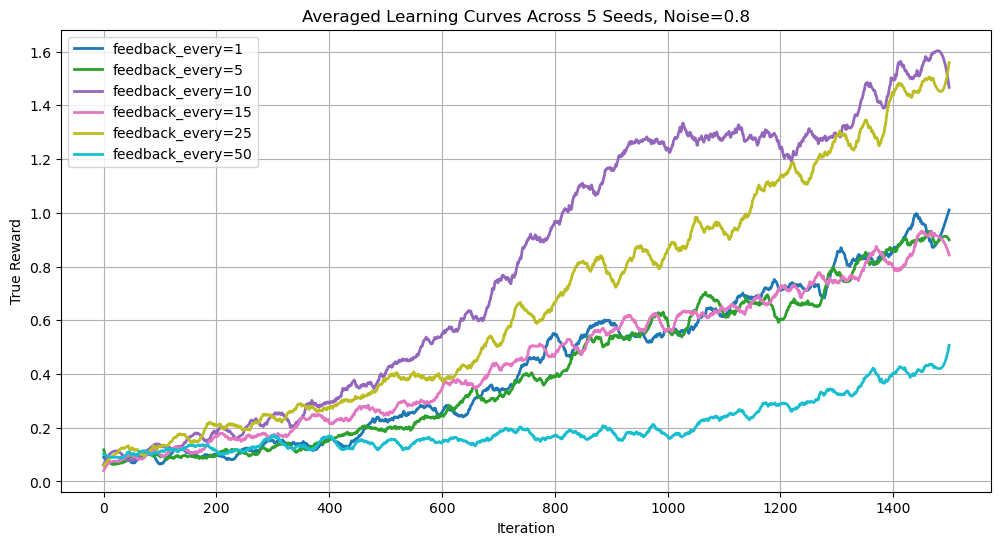

In [10]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np

plt.figure(figsize=(12,6))
colors = plt.cm.tab10(np.linspace(0, 1, len(feedbacks)))

for idx, fb in enumerate(feedbacks):
    mean_curve = mean_curves[fb]
    smooth_mean = savgol_filter(mean_curve, 51, 3)

    plt.plot(
        smooth_mean,
        linewidth=2,
        color=colors[idx],
        label=f"feedback_every={fb}"
    )

plt.xlabel("Iteration")
plt.ylabel("True Reward")
plt.title(f"Averaged Learning Curves Across {num_seeds} Seeds, Noise={noise}")
plt.grid()
plt.legend()
plt.show()


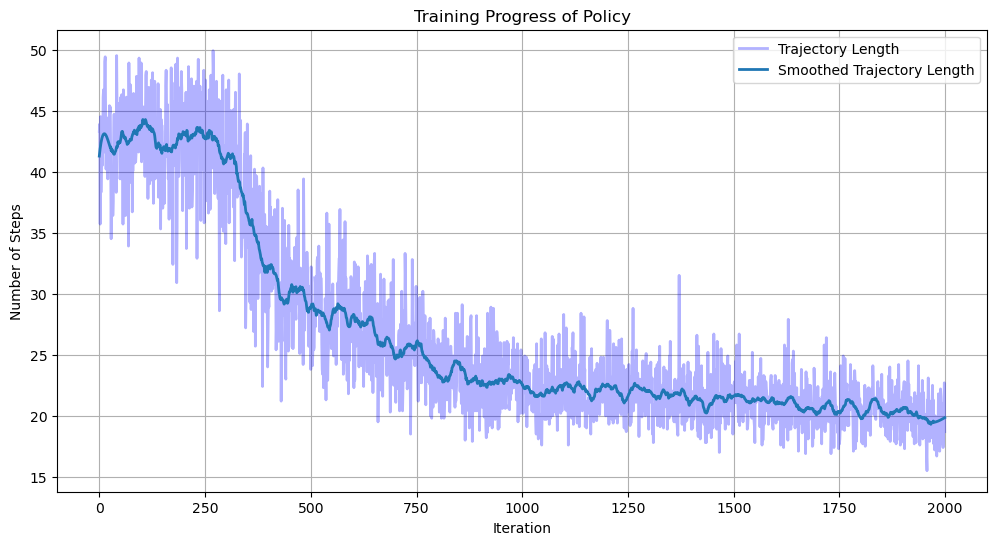

In [60]:
smooth_len = savgol_filter(avg_length, window_length=51, polyorder=3)

plt.figure(figsize=(12,6))

# noisy curve (faded)
plt.plot(avg_length, label="Trajectory Length", linewidth=2, alpha=0.3, color='blue')

plt.plot(smooth_len, label="Smoothed Trajectory Length", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Number of Steps")
plt.title("Training Progress of Policy")
plt.legend()
plt.grid()
plt.show()


In [19]:
# import numpy as np
# def quantize_reward(raw_reward, k):
#     # map raw_reward in [0, max_reward] to {0,...,k-1}
#     max_r = 5
#     bins = np.linspace(0, max_r+1e-8, k+1)  # k equal bins
#     return int(np.digitize(raw_reward, bins) - 1)
# print(quantize_reward(1,10))

1


In [436]:
pi = trained_policy
R = trained_reward_model
print(pi)
print(R)

In [437]:
import matplotlib.pyplot as plt

def plot_gridworld_path(env, states):
    size = env.size
    xs = [s[1] for s in states]
    ys = [s[0] for s in states]
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(size + 1):
        ax.axhline(i - 0.5, linewidth=0.6)
        ax.axvline(i - 0.5, linewidth=0.6)
    ax.set_xlim(-0.5, size - 0.5)
    ax.set_ylim(-0.5, size - 0.5)
    ax.set_aspect('equal', adjustable='box')
    ax.invert_yaxis()
    ax.plot(xs, ys, marker='o', linewidth=1.5, label='path')
    if states:
        ax.scatter(xs[0], ys[0], marker='o', s=100, label='start')
        ax.scatter(xs[-1], ys[-1], marker='D', s=100, label='end')
    gx, gy = env.goal
    dx, dy = env.danger
    ax.scatter(gy, gx, marker='^', s=140, label='goal')     
    ax.scatter(dy, dx, marker='X', s=140, label='danger')
    init_coins = list(env._init_coins)
    remaining = list(env.coins)                
    collected = list(env.collected_coins)       

    if init_coins:
        ax.scatter([c[1] for c in init_coins], [c[0] for c in init_coins], marker='s', s=80, alpha=0.25, label='coin tiles (all)')

    if remaining:
        ax.scatter([c[1] for c in remaining], [c[0] for c in remaining], marker='s', s=80, label='coins (remaining)')

    if collected:
        ax.scatter([c[1] for c in collected], [c[0] for c in collected], marker='*', s=180, label='coins (collected)')

    ax.set_xticks(range(size))
    ax.set_yticks(range(size))
    ax.set_xlabel('y (column)')
    ax.set_ylabel('x (row)')
    ax.set_title('GridWorld trajectory')

    ax.legend(loc='upper right', fontsize=8)
    plt.show()


coin found at position: (6, 2)
coin found at position: (1, 1)
coin found at position: (1, 3)
goal reached!
40


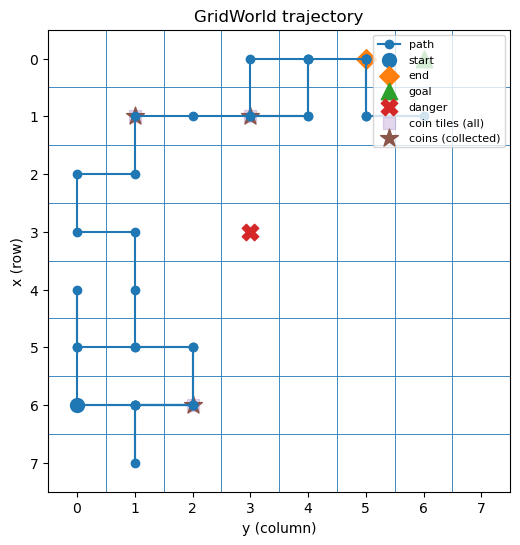

In [444]:
done = 0
traj = {"states": [], "actions": [], "steps": 0, "coins": 0}
env = GridWorld(6,7,size=8, danger=(3,3), goal=(0,6), coins=[(1,1),(1,3),(6,2)], horizon=50) ##set value of k here

s = env.reset() 
c = set([(1,1),(1,3),(6,2)])
while not done:
    a, _ = pi.act(s)
    traj["states"].append(s)
    traj["actions"].append(a)
    s, done = env.step(a)
    if (s in c):
        print(f"coin found at position: {s}")
        c.remove(s)
    if (s == env.goal):
        print("goal reached!")
    if (s == env.danger):
        print("danger zone")
print(env.t)

plot_gridworld_path(env, traj["states"])
